In [60]:
import os
import cv2
import json
import shutil
import random
import numpy as np
import glob
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
from src.create_annotations import *
from shapely.geometry import Polygon, MultiPolygon


In [61]:
# Label ids of the dataset
category_ids = {
    "non": 0,
    "affected": 1,
}

# Define which colors match which categories in the images
category_colors = {
    "(0, 0, 0)": 0, # normal
    "(255, 255, 255)": 1, # affected
}

# Define the ids that are a multipolygon.
multipolygon_ids = [1]

In [62]:
# Get "images" and "annotations" info
def images_annotations_info(maskpath):
    # This id will be automatically increased as we go
    annotation_id = 0
    image_id = 0
    annotations = []
    images = []
    
    for mask_image in glob.glob(maskpath + "*.png"):
        # The mask image is *.png but the original image is *.jpg.
        # We make a reference to the original file in the COCO JSON file
        original_file_name = os.path.basename(mask_image).split("_segmentation.")[0] + ".jpg"

        # Open the image and (to be sure) we convert it to RGB
        mask_image_open = Image.open(mask_image).convert("RGB")
        w, h = mask_image_open.size
        
        # "images" info 
        image = create_image_annotation(original_file_name, w, h, image_id)
        images.append(image)

        sub_masks = create_sub_masks(mask_image_open, w, h)
        has_class_1 = False
        for color, sub_mask in sub_masks.items():
            category_id = category_colors[color]

            # "annotations" info
            polygons, segmentations = create_sub_mask_annotation(sub_mask)

            # Check if we have classes that are a multipolygon
            if category_id in multipolygon_ids:
                # Combine the polygons to calculate the bounding box and area
                multi_poly = MultiPolygon(polygons)
                                
                annotation = create_annotation_format(multi_poly, segmentations, image_id, category_id, annotation_id)

                annotations.append(annotation)
                annotation_id += 1
            else:
                for i in range(len(polygons)):
                    # Cleaner to recalculate this variable
                    segmentation = [np.array(polygons[i].exterior.coords).ravel().tolist()]
                    
                    annotation = create_annotation_format(polygons[i], segmentation, image_id, category_id, annotation_id)
                    
                    annotations.append(annotation)
                    annotation_id += 1
                    if category_id == 1:
                        has_class_1 = True
        if not has_class_1:
            # Add a background annotation for the entire image
            annotation = create_annotation_format(Polygon([(0, 0), (w, 0), (w, h), (0, h)]), [[0, 0, w, 0, w, h, 0, h]], image_id, 0, annotation_id)
            annotations.append(annotation)
            annotation_id += 1

        image_id += 1
    return images, annotations, annotation_id



In [63]:
if __name__ == "__main__":
    # Get the standard COCO JSON format
    coco_format = get_coco_json_format()
    
    for keyword in ["input_images"]:
        mask_path = "dataset/{}_mask/".format(keyword)
        
        # Create category section
        coco_format["categories"] = create_category_annotation(category_ids)
    
        # Create images and annotations sections
        coco_format["images"], coco_format["annotations"], annotation_cnt = images_annotations_info(mask_path)

        output_dir = "dataset/output/"
        os.makedirs(output_dir, exist_ok=True)  # Create the output directory if it doesn't exist

        with open(os.path.join(output_dir, "{}.json".format(keyword)), "w") as outfile:
            json.dump(coco_format, outfile)

        print("Created %d annotations for images in folder: %s" % (annotation_cnt, mask_path))


Created 19 annotations for images in folder: dataset/input_images_mask/


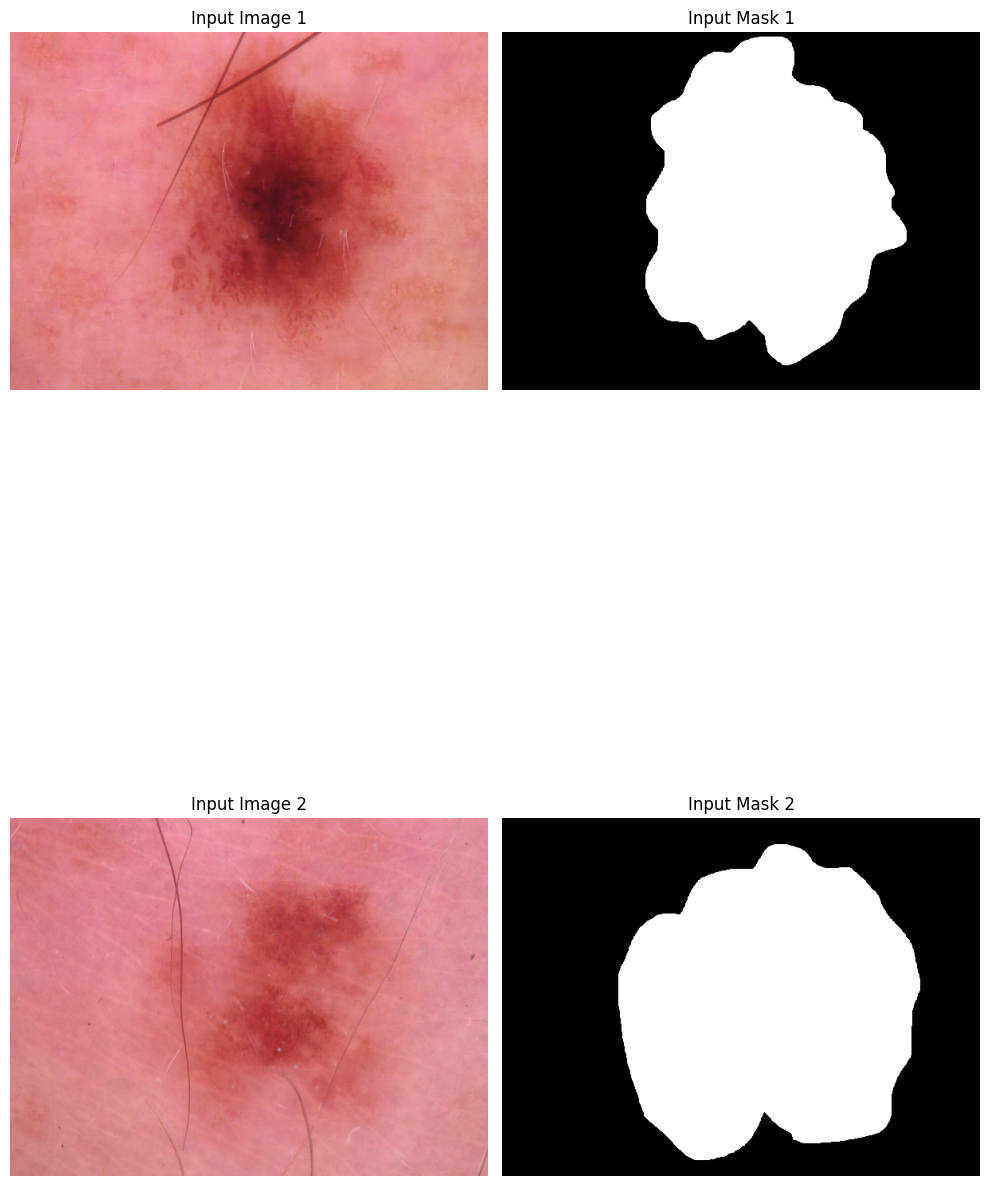

In [85]:

# Path to the dataset directory
dataset_dir = "dataset/"

# Path to the input images and masks directories
input_images_dir = os.path.join(dataset_dir, "input_images/")
input_masks_dir = os.path.join(dataset_dir, "input_images_mask/")

# Get the list of files in the input images directory
input_image_files = os.listdir(input_images_dir)[:2]

# Get the corresponding mask file names
input_mask_files = [file.replace(".jpg", "_segmentation.png") for file in input_image_files]

# Display the images and masks
fig, axes = plt.subplots(2, 2, figsize=(10, 20))

for i, (input_image_file, input_mask_file) in enumerate(zip(input_image_files, input_mask_files)):
    # Load and display the input image
    input_image_path = os.path.join(input_images_dir, input_image_file)
    input_image = plt.imread(input_image_path)
    axes[i, 0].imshow(input_image)
    axes[i, 0].axis('off')
    axes[i, 0].set_title(f"Input Image {i+1}")

    # Load and display the input mask
    input_mask_path = os.path.join(input_masks_dir, input_mask_file)
    input_mask = plt.imread(input_mask_path)
    axes[i, 1].imshow(input_mask, cmap='gray')
    axes[i, 1].axis('off')
    axes[i, 1].set_title(f"Input Mask {i+1}")

plt.tight_layout()
plt.show()
